In [1]:
# check available GPU
# this notebook was ran on google colab's T4 GPU (free version)
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Jan  8 14:01:35 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


In [4]:
# get data docs file from google drive
from google.colab import drive

drive.mount('/content/drive', force_remount=False)
project_folder_path = '/content/drive/MyDrive/bertopic llama2/'

Mounted at /content/drive


In [6]:
# docs data path from google drive
data_path = f"{project_folder_path}askreddit_whats_your_reason_for_not_drinking_alcohol_clean_text.parquet"
data_path

'/content/drive/MyDrive/bertopic llama2/askreddit_whats_your_reason_for_not_drinking_alcohol_clean_text.parquet'

# **Topic Modeling with Llama2** 🦙
*Create easily interpretable topics with BERTopic and Llama 2*
<br>
<div>
<img src="https://github.com/MaartenGr/BERTopic/assets/25746895/35441954-4405-465c-97f7-a57ee91315b8" width="750"/>
</div>


We will explore how we can use Llama2 for Topic Modeling without the need to pass every single document to the model. Instead, we are going to leverage BERTopic, a modular topic modeling technique that can use any LLM for fine-tuning topic representations.

BERTopic works rather straightforward. It consists of 5 sequential steps: embedding documents, reducing embeddings in dimensionality, cluster embeddings, tokenize documents per cluster, and finally extract the best representing words per topic.
<br>
<div>
<img src="https://github.com/MaartenGr/BERTopic/assets/25746895/e9b0d8cf-2e19-4bf1-beb4-4ff2d9fa5e2d" width="500"/>
</div>

However, with the rise of LLMs like **Llama 2**, we can do much better than a bunch of independent words per topic. It is computally not feasible to pass all documents to Llama 2 directly and have it analyze them. We can employ vector databases for search but we are not entirely search which topics to search for.

Instead, we will leverage the clusters and topics that were created by BERTopic and have Llama 2 fine-tune and distill that information into something more accurate.

This is the best of both worlds, the topic creation of BERTopic together with the topic representation of Llama 2.
<br>
<div>
<img src="https://github.com/MaartenGr/BERTopic/assets/25746895/7c7374a1-5b41-4e93-aafd-a1587367767b" width="500"/>
</div>

Now that this intro is out of the way, let's start the hands-on tutorial!

---
        
💡 **NOTE**: We will want to use a GPU to run both Llama2 as well as BERTopic for this use case. In Google Colab, go to
**Runtime > Change runtime type > Hardware accelerator > GPU > GPU type > T4**.

---

We will start by installing a number of packages that we are going to use throughout this example:

In [7]:
%%capture
!pip install bertopic accelerate bitsandbytes xformers adjustText

# 📄 **Data**

We are going to apply topic modeling on a number of Reddit posts from the following submission: https://www.reddit.com/r/AskReddit/comments/1hg10tp/whats_your_reason_for_not_drinking_alcohol/

This analysis will give us some insights into the reasons people on reddit give for not driniking alcohol.

The comments were extracted using the Praw library and reddit official API. All text was cleaned in a previous notebook.

In [10]:
import pandas as pd

# load data
data = pd.read_parquet(data_path)
docs = data['comment_body_clean'] # posts to train on
docs

0                           i grew up around alcohol abuse
1        because i always overdo it and have a hard tim...
2        social drinker and not a social person most times
3        can not handle the hangovers anymore they now ...
4        i don t like the person i can t remember that ...
                               ...                        
14853    i would say it fits in my original list of cat...
14854    wtf are you talking about a strawman and gasli...
14855    because i feel inclined to stick up for what i...
14856    the gaslight is that i didn t say it s not a n...
14857    fair and lucky you that it works my sister sai...
Name: comment_body_clean, Length: 14858, dtype: object

To give you an idea, reddit post, after text was cleaned, looks like the following:

In [11]:
# example of post text
print(docs[14853])

i would say it fits in my original list of categories of things that are bad for you but make you feel good i put the food that you eat which is very vague but in this context we all seem to understand i am not talking about a banana right


In [12]:
len(docs)

14858

# 🤗 HuggingFace Hub Credentials
Before we can load in Llama2 using a number of tricks, we will first need to accept the License for using Llama2. The steps are as follows:


* Create a HuggingFace account [here](https://huggingface.co)
* Apply for Llama 2 access [here](https://huggingface.co/meta-llama/Llama-2-13b-chat-hf)
* Get your HuggingFace token [here](https://huggingface.co/settings/tokens)

After doing so, we can login with our HuggingFace credentials so that this environment knows we have permission to download the Llama 2 model that we are interested in.

In [13]:
from huggingface_hub import notebook_login

# login to hugging face do access the llama2 model
notebook_login()

# 🦙 **Llama 2**


We will be focusing on the `'meta-llama/Llama-2-7b-chat-hf'` variant. It is large enough to give interesting and useful results whilst small enough that it can be run on our environment.

We start by defining our model and identifying if our GPU is correctly selected. We expect the output of `device` to show a cuda device:

In [14]:
from torch import cuda

model_id = 'meta-llama/Llama-2-7b-chat-hf'
device = f'cuda:{cuda.current_device()}' if cuda.is_available() else 'cpu'

print(device)

cuda:0


## **Optimization & Quantization**

In order to load our 13 billion parameter model, we will need to perform some optimization tricks. Since we have limited VRAM and not an A100 GPU, we will need to "condense" the model a bit so that we can run it.

There are a number of tricks that we can use but the main principle is going to be 4-bit quantization.

This process reduces the 64-bit representation to only 4-bits which reduces the GPU memory that we will need. It is a recent technique and quite an elegant at that for efficient LLM loading and usage. You can find more about that method [here](https://arxiv.org/pdf/2305.14314.pdf) in the QLoRA paper and on the amazing HuggingFace blog [here](https://huggingface.co/blog/4bit-transformers-bitsandbytes).

In [15]:
from torch import bfloat16
import transformers

# set quantization configuration to load large model with less GPU memory
# this requires the `bitsandbytes` library

bnb_config = transformers.BitsAndBytesConfig(
    load_in_4bit=True,  # 4-bit quantization
    bnb_4bit_quant_type='nf4',  # Normalized float 4
    bnb_4bit_use_double_quant=True,  # Second quantization after the first
    bnb_4bit_compute_dtype=bfloat16  # Computation type
)

These four parameters that we just run are incredibly important and bring many LLM applications to consumers:
* `load_in_4bit`
  * Allows us to load the model in 4-bit precision compared to the original 32-bit precision
  * This gives us an incredibly speed up and reduces memory!
* `bnb_4bit_quant_type`
  * This is the type of 4-bit precision. The paper recommends normalized float 4-bit, so that is what we are going to use!
* `bnb_4bit_use_double_quant`
  * This is a neat trick as it perform a second quantization after the first which further reduces the necessary bits
* `bnb_4bit_compute_dtype`
  * The compute type used during computation, which further speeds up the model.



Using this configuration, we can start loading in the model as well as the tokenizer:

In [16]:
# Llama 2 Tokenizer
tokenizer = transformers.AutoTokenizer.from_pretrained(model_id)

# Llama 2 Model
model = transformers.AutoModelForCausalLM.from_pretrained(
    model_id,
    trust_remote_code=True,
    quantization_config=bnb_config,
    device_map='auto',
)
model.eval()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.62k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/188 [00:00<?, ?B/s]

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=11008, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear4bit(in_features=11008, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((4096,), eps=

Using the model and tokenizer, we will generate a HuggingFace transformers pipeline that allows us to easily generate new text:

In [17]:
# Our text generator
generator = transformers.pipeline(
    model=model, tokenizer=tokenizer,
    task='text-generation',
    temperature=0.1,
    max_new_tokens=500,
    repetition_penalty=1.1
)

Device set to use cuda:0


## **Prompt Engineering**

To check whether our model is correctly loaded, let's try it out with a few prompts.

In [18]:
prompt = "Could you tell me two reasons people give for not drinking alcohol?"
res = generator(prompt)
print(res[0]["generated_text"])

Could you tell me two reasons people give for not drinking alcohol?
 nobody likes the taste of beer.
I don't like the way it makes me feel after I drink it.


Although we can directly prompt the model, there is actually a template that we need to follow. The template looks as follows:

```python
"""
<s>[INST] <<SYS>>

{{ System Prompt }}

<</SYS>>

{{ User Prompt }} [/INST]

{{ Model Answer }}
"""
```

This template consists of two main components, namely the `{{ System Prompt }}` and the `{{ User Prompt }}`:
* The `{{ System Prompt }}` helps us guide the model during a conversation. For example, we can say that it is a helpful assisant that is specialized in labeling topics.
* The  `{{ User Prompt }}` is where we ask it a question.

You might have noticed the `[INST]` tags, these are used to identify the beginning and end of a prompt. We can use these to model the conversation history as we will see more in-depth later on.

Next, let's see how we can use this template to optimize Llama 2 for topic modeling.

### **Prompt Template**

We are going to keep our `system prompt` simple and to the point:

In [19]:
# System prompt describes information given to all conversations
system_prompt = """
<s>[INST] <<SYS>>
You are a helpful, respectful and honest assistant for labeling topics.
<</SYS>>
"""

We will tell the model that it is simply a helpful assistant for labeling topics since that is our main goal.

In contrast, our `user prompt` is going to the be a bit more involved. It will consist of two components, an **example** and the **main prompt**.

Let's start with the **example**. Most LLMs do a much better job of generating accurate responses if you give them an example to work with. We will show it an accurate example of the kind of output we are expecting.

In [20]:
# Example prompt demonstrating the output we are looking for
example_prompt = """
I have a topic that contains the following documents:
- Traditional diets in most cultures were primarily plant-based with a little meat on top, but with the rise of industrial style meat production and factory farming, meat has become a staple food.
- Meat, but especially beef, is the word food in terms of emissions.
- Eating meat doesn't make you a bad person, not eating meat doesn't make you a good one.

The topic is described by the following keywords: 'meat, beef, eat, eating, emissions, steak, food, health, processed, chicken'.

Based on the information about the topic above, please create a short label of this topic. Make sure you to only return the label and nothing more.

[/INST] Environmental impacts of eating meat
"""

This example, based on a number of keywords and documents primarily about the impact of
meat, helps to model to understand the kind of output it should give. We show the model that we were expecting only the label, which is easier for us to extract.

Next, we will create a template that we can use within BERTopic:

In [21]:
# Our main prompt with documents ([DOCUMENTS]) and keywords ([KEYWORDS]) tags
# this prompt was is the same used in the BERTopic llama2 tutorial
main_prompt = """
[INST]
I have a topic that contains the following documents:
[DOCUMENTS]

The topic is described by the following keywords: '[KEYWORDS]'.

Based on the information about the topic above, please create a short label of this topic. Make sure you to only return the label and nothing more.
[/INST]
"""

There are two BERTopic-specific tags that are of interest, namely `[DOCUMENTS]` and `[KEYWORDS]`:

* `[DOCUMENTS]` contain the top 5 most relevant documents to the topic
* `[KEYWORDS]` contain the top 10 most relevant keywords to the topic as generated through c-TF-IDF

This template will be filled accordingly to each topic. And finally, we can combine this into our final prompt:

In [22]:
prompt = system_prompt + example_prompt + main_prompt

# 🗨️ **BERTopic**

Before we can start with topic modeling, we will first need to perform two steps:
* Pre-calculating Embeddings
* Defining Sub-models

## **Preparing Embeddings**

By pre-calculating the embeddings for each document, we can speed-up additional exploration steps and use the embeddings to quickly iterate over BERTopic's hyperparameters if needed.

🔥 **TIP**: You can find a great overview of good embeddings for clustering on the [MTEB Leaderboard](https://huggingface.co/spaces/mteb/leaderboard).

In [23]:
from sentence_transformers import SentenceTransformer

# Pre-calculate embeddings
embedding_model = SentenceTransformer("BAAI/bge-small-en")
embeddings = embedding_model.encode(docs, show_progress_bar=True)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/90.8k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/465 [00:00<?, ?it/s]

## **Sub-models**

Next, we will define all sub-models in BERTopic and do some small tweaks to the number of clusters to be created, setting random states, etc.

In [46]:
from umap import UMAP
from hdbscan import HDBSCAN

umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', random_state=42)
hdbscan_model = HDBSCAN(min_cluster_size=30, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

As a small bonus, we are going to reduce the embeddings we created before to 2-dimensions so that we can use them for visualization purposes when we have created our topics.

In [47]:
# Pre-reduce embeddings for visualization purposes
reduced_embeddings = UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine', random_state=42).fit_transform(embeddings)

### **Representation Models**

One of the ways we are going to represent the topics is with Llama 2 which should give us a nice label. However, we might want to have additional representations to view a topic from multiple angles.

Here, we will be using c-TF-IDF as our main representation and [KeyBERT](https://maartengr.github.io/BERTopic/getting_started/representation/representation.html#keybertinspired), [MMR](https://maartengr.github.io/BERTopic/getting_started/representation/representation.html#maximalmarginalrelevance), and [Llama 2](https://maartengr.github.io/BERTopic/getting_started/representation/llm.html) as our additional representations.

In [48]:
from bertopic.representation import KeyBERTInspired, MaximalMarginalRelevance, TextGeneration

# KeyBERT
keybert = KeyBERTInspired()

# MMR
mmr = MaximalMarginalRelevance(diversity=0.3)

# Text generation with Llama 2
llama2 = TextGeneration(generator, prompt=prompt)

# All representation models
representation_model = {
    "KeyBERT": keybert,
    "Llama2": llama2,
    "MMR": mmr,
}

# 🔥 **Training**

Now that we have our models prepared, we can start training our topic model! We supply BERTopic with the sub-models of interest, run `.fit_transform`, and see what kind of topics we get.

In [49]:
from bertopic import BERTopic

topic_model = BERTopic(

  # Sub-models
  embedding_model=embedding_model,
  umap_model=umap_model,
  hdbscan_model=hdbscan_model,
  representation_model=representation_model,

  # Hyperparameters
  top_n_words=10,
  verbose=True
)

# Train model
topics, probs = topic_model.fit_transform(docs, embeddings)

2025-01-08 14:39:31,106 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-01-08 14:39:48,024 - BERTopic - Dimensionality - Completed ✓
2025-01-08 14:39:48,030 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-01-08 14:39:49,495 - BERTopic - Cluster - Completed ✓
2025-01-08 14:39:49,503 - BERTopic - Representation - Extracting topics from clusters using representation models.
100%|██████████| 45/45 [03:13<00:00,  4.29s/it]
2025-01-08 14:43:06,364 - BERTopic - Representation - Completed ✓


Now that we are done training our model, let's see what topics were generated:

In [50]:
# Show topics
topic_model.get_topic_info()

Topic  Count                                         Name  \
0      -1   7154                             -1_and_to_the_it   
1       0   1245                              0_my_he_was_dad   
2       1    566                       1_taste_tastes_like_it   
3       2    515                      2_taste_like_tastes_the   
4       3    460                    3_stomach_feel_sick_makes   
5       4    417                        4_years_sober_was_and   
6       5    372                   5_meds_medication_with_mix   
7       6    269          6_hangovers_hangover_worth_hungover   
8       7    255                           7_work_at_am_right   
9       8    243                   8_weed_smoke_better_prefer   
10      9    213                        9_control_want_do_don   
11     10    212     10_migraines_migraine_headache_headaches   
12     11    204          11_allergic_break_handcuffs_allergy   
13     12    198                      12_wife_she_her_husband   
14     13    173             13_liver_kidney_fatty_transplant   
15     14    143                   14_you_username_proud_your   
16     15    140                    15_never_just_it_interest   
17     16    138                            16_not_like_do_of   
18     17    138                  17_poison_body_it_literally   
19     18    130                  18_reason_what_question_why   
20     19    120                    19_drunk_when_want_people   
21     20    117  20_addicted_addictive_personality_addiction   
22     21    102           21_religion_muslim_religious_islam   
23     22     94                       22_next_day_feel_makes   
24     23     91                   23_never_reason_have_drink   
25     24     88                      24_taste_family_my_like   
26     25     88                  25_sleep_asleep_tired_makes   
27     26     83     26_pregnant_baby_breastfeeding_pregnancy   
28     27     79                     27_poison_is_alcohol_you   
29     28     71                28_expensive_money_too_afford   
30     29     68                29_weight_calories_better_and   
31     30     67                30_social_alone_drinker_drink   
32     31     67                           31_never_was_my_to   
33     32     63                   32_calories_empty_eat_many   
34     33     55              33_blackout_black_out_blackouts   
35     34     50              34_water_hangover_you_hangovers   
36     35     48             35_cancer_breast_risk_recurrence   
37     36     48                     36_comment_you_same_what   
38     37     44                       37_stop_start_once_can   
39     38     44                  38_alcoholic_would_start_if   
40     39     43              39_money_spend_things_expensive   
41     40     40          40_pancreatitis_pancreas_pain_acute   
42     41     36                    41_car_drive_license_home   
43     42     35              42_diabetes_sugar_diabetic_type   
44     43     32             43_health_better_mental_physical   

                                       Representation  \
0   [and, to, the, it, not, of, is, that, have, dr...   
1   [my, he, was, dad, family, his, and, alcoholic...   
2   [taste, tastes, like, it, bad, don, the, expen...   
3   [taste, like, tastes, the, alcohol, it, not, o...   
4   [stomach, feel, sick, makes, me, my, it, and, ...   
5   [years, sober, was, and, to, my, the, for, of,...   
6   [meds, medication, with, mix, take, on, medica...   
7   [hangovers, hangover, worth, hungover, day, th...   
8   [work, at, am, right, currently, because, ran,...   
9   [weed, smoke, better, prefer, feel, smoking, i...   
10  [control, want, do, don, not, reason, to, like...   
11  [migraines, migraine, headache, headaches, get...   
12  [allergic, break, handcuffs, allergy, red, asi...   
13  [wife, she, her, husband, we, my, and, alcohol...   
14  [liver, kidney, fatty, transplant, my, disease...   
15  [you, username, proud, your, thank, hope, glad...   
16  [never, just, it, interest, do, not, don

In [51]:
topic_model.get_topic(1, full=True)["KeyBERT"]

[('tastes', 0.909122),
 ('taste', 0.9053554),
 ('disgusting', 0.87256324),
 ('nasty', 0.87091017),
 ('smells', 0.8667969),
 ('smell', 0.8661852),
 ('hate', 0.85538226),
 ('gross', 0.8495807),
 ('piss', 0.8458344),
 ('awful', 0.84214735)]

We got over 40 topics that were created and they all seem quite diverse.We can use the labels by Llama 2 and assign them to topics that we have created. Normally, the default topic representation would be c-TF-IDF, but we will focus on Llama 2 representations instead.


In [52]:
llama2_labels = [label[0][0].split("\n")[0] for label in topic_model.get_topics(full=True)["Llama2"].values()]
topic_model.set_topic_labels(llama2_labels)

# 📊 **Visualize**
We can go through each topic manually, which would take a lot of work, or we can visualize them all in a single interactive graph.
BERTopic has a bunch of [visualization functions](https://medium.com/r/?url=https%3A%2F%2Fmaartengr.github.io%2FBERTopic%2Fgetting_started%2Fvisualization%2Fvisualize_documents.html) that we can use. For now, we are sticking with visualizing the documents.

In [54]:
topic_model.visualize_documents(docs, reduced_embeddings=reduced_embeddings, hide_annotations=True, hide_document_hover=False, custom_labels=True)

# 🖼️ (BONUS): **Advanced Visualization**

Although we can use the built-in visualization features of BERTopic, we can also create a static visualization that might be a bit more informative.

We start by creating the necessary variables that contain our reduced embeddings and representations:

In [120]:
import numpy as np
import colorsys
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from adjustText import adjust_text
import matplotlib.patheffects as pe
import textwrap

def generate_distinct_colors(n):
    """Generate n distinct colors using HSV color space."""
    colors = []
    for i in range(n):
        hue = i / n
        saturation = 0.7 + np.random.uniform(-0.2, 0.2)  # Add some variation
        value = 0.9 + np.random.uniform(-0.2, 0.2)  # Add some variation
        rgb = colorsys.hsv_to_rgb(hue, saturation, value)
        # Convert to hex - fix formatting to ensure 6 digits
        hex_color = '#{:02x}{:02x}{:02x}'.format(
            min(255, max(0, int(rgb[0] * 255))),
            min(255, max(0, int(rgb[1] * 255))),
            min(255, max(0, int(rgb[2] * 255)))
        )
        colors.append(hex_color)
    return colors

# Get unique topics and generate colors
unique_topics = sorted(set(topic_model.topics_))
unique_topics = [t for t in unique_topics if t != -1]  # Remove -1 if it exists
colors = generate_distinct_colors(len(unique_topics))
color_key = {str(topic): colors[i] for i, topic in enumerate(unique_topics)}

# Prepare dataframe and ignore outliers (topic "-1")
df = pd.DataFrame({
    "x": reduced_embeddings[:, 0],
    "y": reduced_embeddings[:, 1],
    "Topic": [str(t) for t in topic_model.topics_]
})
df["Length"] = [len(doc) for doc in docs]
df = df.loc[df.Topic != "-1"]
df = df.loc[(df.y > -10) & (df.y < 10) & (df.x < 10) & (df.x > -10)]



Plot the topics datamap

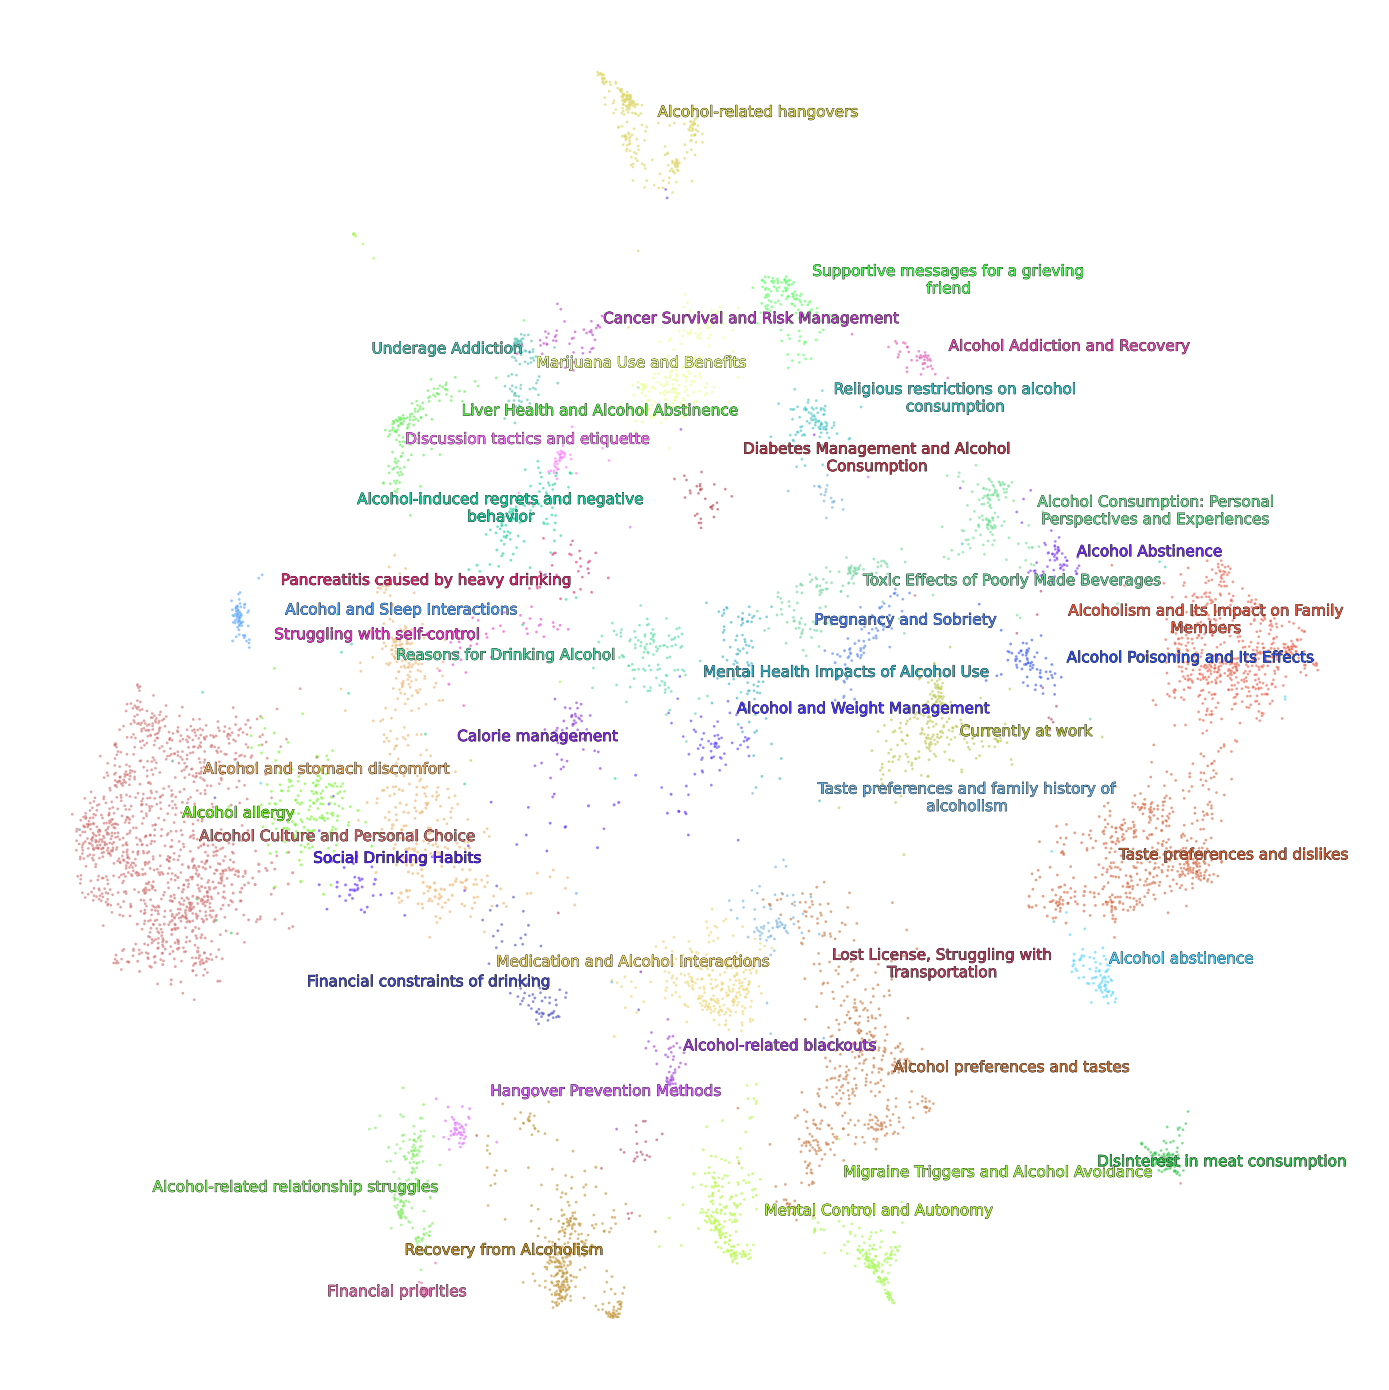

In [121]:
# Get centroids of clusters
mean_df = df.groupby("Topic").mean().reset_index()
mean_df["Topic"] = mean_df["Topic"].astype(int)
mean_df = mean_df.sort_values("Topic")

# Create the plot
fig, ax = plt.subplots(figsize=(14, 14))

# Create scatter plot
scatter = sns.scatterplot(
    data=df,
    x='x',
    y='y',
    hue='Topic',
    palette=color_key,
    alpha=0.6,
    size="Length",
    sizes=(4, 10),
    legend=False
)

# Annotate all topics
texts = []
for _, row in mean_df.iterrows():
    topic = row["Topic"]
    name = textwrap.fill(topic_model.custom_labels_[int(topic)], 40)
    text = plt.text(
        row["x"],
        row["y"],
        name,
        size=11,
        ha="center",
        color=color_key[str(int(topic))],
        path_effects=[pe.withStroke(linewidth=0.5, foreground="black")]
    )
    texts.append(text)

# Adjust annotations to prevent overlap
adjust_text(
    texts,
    x=mean_df['x'],
    y=mean_df['y'],
    time_lim=2,
    force_text=(0.01, 0.02),
    force_static=(0.01, 0.02),
    force_pull=(0.5, 0.5)
)

plt.axis('off')
plt.tight_layout()
plt.show()

Save the data files

In [109]:
# Get topic info and save to parquet
topic_info_df = topic_model.get_topic_info()
topic_info_df.to_parquet(f'{project_folder_path}askreddit_whats_your_reason_for_not_drinking_alcohol_llama2_topic_info.parquet', index=False)


In [114]:
docs_with_topics = topic_model.get_document_info(docs)
docs_with_topics.head(3)

Document  Topic  \
0                     i grew up around alcohol abuse      0   
1  because i always overdo it and have a hard tim...     37   
2  social drinker and not a social person most times     30   

                            Name                                   CustomName  \
0                0_my_he_was_dad  Alcoholism and Its Impact on Family Members   
1         37_stop_start_once_can                 Struggling with self-control   
2  30_social_alone_drinker_drink                       Social Drinking Habits   

                                      Representation  \
0  [my, he, was, dad, family, his, and, alcoholic...   
1  [stop, start, once, can, know, because, never,...   
2  [social, alone, drinker, drink, friends, only,...   

                                             KeyBERT  \
0  [alcoholism, alcoholic, alcoholics, alcohol, d...   
1  [started, stopping, start, stopped, stop, brea...   
2  [drinking, socially, drinker, social, socializ...   

                                              Llama2  \
0  [Alcoholism and Its Impact on Family Members, ...   
1   [Struggling with self-control, , , , , , , , , ]   
2         [Social Drinking Habits, , , , , , , , , ]   

                                                 MMR  \
0  [dad, family, his, alcoholic, an, father, the,...   
1  [once, know, started, overdo, stopping, won, s...   
2  [social, alone, drinker, friends, socially, dr...   

                                 Representative_Docs  \
0  [three reasons in 1970 i was six years old and...   
1  [if i start i can t stop myself, because i don...   
2  [i am a social drinker and that s about it, i ...   

                                         Top_n_words  Probability  \
0  my - he - was - dad - family - his - and - alc...     0.799035   
1  stop - start - once - can - know - because - n...     1.000000   
2  social - alone - drinker - drink - friends - o...     0.928846   

   Representative_document  
0                    False  
1                    False  
2                    False

In [116]:
df_merged = data.join(docs_with_topics.set_index(data.index))
df_merged = df_merged.drop(columns=['Document'])
df_merged.head(3)

main_submission_id       comment_author  \
0            1hg10tp        Totallycasual   
1            1hg10tp       666Needle-Dick   
2            1hg10tp  PurposeDramatic2468   

                                        comment_body comment_id  \
0                    I grew up around alcohol abuse.    m2fq33p   
1  Because I always overdo it and have a hard tim...    m2fsp7h   
2  Social drinker, and not a social person most t...    m2fqdvq   

    comment_date_time  comment_score comment_parent_id comment_subreddit  \
0 2024-12-17 02:57:11           6032        t3_1hg10tp         AskReddit   
1 2024-12-17 03:13:35           9961        t3_1hg10tp         AskReddit   
2 2024-12-17 02:59:02           6401        t3_1hg10tp         AskReddit   

                                   comment_permalink  comment_is_submitter  \
0  /r/AskReddit/comments/1hg10tp/whats_your_reaso...                 False   
1  /r/AskReddit/comments/1hg10tp/whats_your_reaso...                 False   
2  /r/AskReddit/comments/1hg10tp/whats_your_reaso...                 False   

   ...                           Name  \
0  ...                0_my_he_was_dad   
1  ...         37_stop_start_once_can   
2  ...  30_social_alone_drinker_drink   

                                    CustomName  \
0  Alcoholism and Its Impact on Family Members   
1                 Struggling with self-control   
2                       Social Drinking Habits   

                                      Representation  \
0  [my, he, was, dad, family, his, and, alcoholic...   
1  [stop, start, once, can, know, because, never,...   
2  [social, alone, drinker, drink, friends, only,...   

                                             KeyBERT  \
0  [alcoholism, alcoholic, alcoholics, alcohol, d...   
1  [started, stopping, start, stopped, stop, brea...   
2  [drinking, socially, drinker, social, socializ...   

                                              Llama2  \
0  [Alcoholism and Its Impact on Family Members, ...   
1   [Struggling with self-control, , , , , , , , , ]   
2         [Social Drinking Habits, , , , , , , , , ]   

                                                 MMR  \
0  [dad, family, his, alcoholic, an, father, the,...   
1  [once, know, started, overdo, stopping, won, s...   
2  [social, alone, drinker, friends, socially, dr...   

                                 Representative_Docs  \
0  [three reasons in 1970 i was six years old and...   
1  [if i start i can t stop myself, because i don...   
2  [i am a social drinker and that s about it, i ...   

                                         Top_n_words Probability  \
0  my - he - was - dad - family - his - and - alc...    0.799035   
1  stop - start - once - can - know - because - n...    1.000000   
2  social - alone - drinker - drink - friends - o...    0.928846   

  Representative_document  
0                   False  
1                   False  
2                   False  

[3 rows x 24 columns]

In [118]:
# Rename columns to be better understood by non DS people
final_df = df_merged.rename(columns={
    'Representative_Docs': 'Representative_Comments(list of examples)',
    'Representative_document': 'Representative_comment'
})

# add the reduced embedings as a column in the dataset
final_df['embeddings'] = list(reduced_embeddings)

final_df.head(3)

main_submission_id       comment_author  \
0            1hg10tp        Totallycasual   
1            1hg10tp       666Needle-Dick   
2            1hg10tp  PurposeDramatic2468   

                                        comment_body comment_id  \
0                    I grew up around alcohol abuse.    m2fq33p   
1  Because I always overdo it and have a hard tim...    m2fsp7h   
2  Social drinker, and not a social person most t...    m2fqdvq   

    comment_date_time  comment_score comment_parent_id comment_subreddit  \
0 2024-12-17 02:57:11           6032        t3_1hg10tp         AskReddit   
1 2024-12-17 03:13:35           9961        t3_1hg10tp         AskReddit   
2 2024-12-17 02:59:02           6401        t3_1hg10tp         AskReddit   

                                   comment_permalink  comment_is_submitter  \
0  /r/AskReddit/comments/1hg10tp/whats_your_reaso...                 False   
1  /r/AskReddit/comments/1hg10tp/whats_your_reaso...                 False   
2  /r/AskReddit/comments/1hg10tp/whats_your_reaso...                 False   

   ...                                   CustomName  \
0  ...  Alcoholism and Its Impact on Family Members   
1  ...                 Struggling with self-control   
2  ...                       Social Drinking Habits   

                                      Representation  \
0  [my, he, was, dad, family, his, and, alcoholic...   
1  [stop, start, once, can, know, because, never,...   
2  [social, alone, drinker, drink, friends, only,...   

                                             KeyBERT  \
0  [alcoholism, alcoholic, alcoholics, alcohol, d...   
1  [started, stopping, start, stopped, stop, brea...   
2  [drinking, socially, drinker, social, socializ...   

                                              Llama2  \
0  [Alcoholism and Its Impact on Family Members, ...   
1   [Struggling with self-control, , , , , , , , , ]   
2         [Social Drinking Habits, , , , , , , , , ]   

                                                 MMR  \
0  [dad, family, his, alcoholic, an, father, the,...   
1  [once, know, started, overdo, stopping, won, s...   
2  [social, alone, drinker, friends, socially, dr...   

           Representative_Comments(list of examples)  \
0  [three reasons in 1970 i was six years old and...   
1  [if i start i can t stop myself, because i don...   
2  [i am a social drinker and that s about it, i ...   

                                         Top_n_words Probability  \
0  my - he - was - dad - family - his - and - alc...    0.799035   
1  stop - start - once - can - know - because - n...    1.000000   
2  social - alone - drinker - drink - friends - o...    0.928846   

  Representative_comment                 embeddings  
0                  False  [0.37043795, 0.074391484]  
1                  False     [2.8681884, 2.1630468]  
2                  False     [4.043455, 0.35864398]  

[3 rows x 25 columns]

In [119]:
final_df.to_parquet(f'{project_folder_path}askreddit_whats_your_reason_for_not_drinking_alcohol_llama2_docs_with_topics.parquet', index=False)


# Backup Saving

In [67]:
# To save: model, reduced embeddings, representative docs
!pip install safetensors

In [68]:
!pwd

/content


In [69]:
import pickle

with open(f'{project_folder_path}rep_docs.pickle', 'wb') as handle:
    pickle.dump(topic_model.representative_docs_, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open(f'{project_folder_path}reduced_embeddings.pickle', 'wb') as handle:
    pickle.dump(reduced_embeddings, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open('filename.pickle', 'rb') as handle:
#     b = pickle.load(handle)

In [70]:
embedding_model = "BAAI/bge-small-en"
topic_model.save(f"{project_folder_path}final", serialization="safetensors", save_ctfidf=True, save_embedding_model=embedding_model)

In [ ]:
!zip -r /content/llama2.zip /content/final

  adding: content/final/ (stored 0%)
  adding: content/final/ctfidf_config.json (deflated 65%)
  adding: content/final/topics.json (deflated 84%)
  adding: content/final/topic_embeddings.safetensors (deflated 7%)
  adding: content/final/ctfidf.safetensors (deflated 47%)
  adding: content/final/config.json (deflated 38%)


In [ ]:
!jupyter nbconvert --to markdown Topic_Modeling_with_Llama2.ipynb

[NbConvertApp] Converting notebook Topic_Modeling_with_Llama2.ipynb to markdown
[NbConvertApp] Support files will be in Topic_Modeling_with_Llama2_files/
[NbConvertApp] Making directory Topic_Modeling_with_Llama2_files
[NbConvertApp] Writing 13754635 bytes to Topic_Modeling_with_Llama2.md
